In [1]:
import os

# Restrict PyTorch to only see GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch

if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available, using CPU.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Number of GPUs available: 1
GPU 0: NVIDIA L40S
Using device: cuda:0


In [62]:
from spatialvla.mobilevlm.model.diffusion_heads import DiffusionPolicyHead
import torch
import torch.optim as optim
from tqdm import tqdm
DiffusionHead = {
    'head_type': 'DiffusionPolicy',
    'hidden_projection': 'pass',
    'use_map' : True,
    'max_action': 5.0,
    'loss_type': 'mse',
    'time_dim':  32,
    'num_blocks': 3,
    'dropout_rate': 0.0,
    'hidden_dim': 256,
    'use_layer_norm':True,
    'diffusion_steps': 20,
    'n_diffusion_samples': 1,
}

In [63]:
model = DiffusionPolicyHead(action_len=8, head_args=DiffusionHead).cuda()

In [64]:
import numpy as np
x = np.linspace(0, 6.28, 7)
y = np.sin(x)
y = torch.Tensor(y).unsqueeze(0).unsqueeze(0).expand(1, 8, 7).cuda()
y.shape

torch.Size([1, 8, 7])

In [65]:
epochs = 1000
learning_rate = 1e-4
batch_size = 16
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [66]:
model.train()
# Training loop
for epoch in tqdm(range(epochs)):
    model.train()     
    optimizer.zero_grad()
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        labels_encoded = torch.zeros(16, 1, 2048).cuda()
        loss = model.loss(labels_encoded, y.expand(batch_size, -1, -1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.97it/s]


In [67]:
loss.item()

0.013198195025324821

In [68]:
p, h = model.predict_action(torch.zeros(1, 1, 2048).cuda(), 20, return_history=True)

In [69]:
h[0].shape

torch.Size([1, 8, 7])

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Assuming `h` is a list of tensors
frames = []

# Loop through each element in `h` to create and save each frame
for h_elem in h:
    # Plot the data
    fig, ax = plt.subplots()
    ax.plot(range(7), h_elem[0, 0].detach().cpu().numpy())

    # Save the plot as an image in memory
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(Image.fromarray(image))

    # Close the figure to avoid display overlap and memory issues
    plt.close(fig)

# Save frames as an animated GIF
frames[0].save("animation.gif", save_all=True, append_images=frames[1:], loop=0, duration=200)


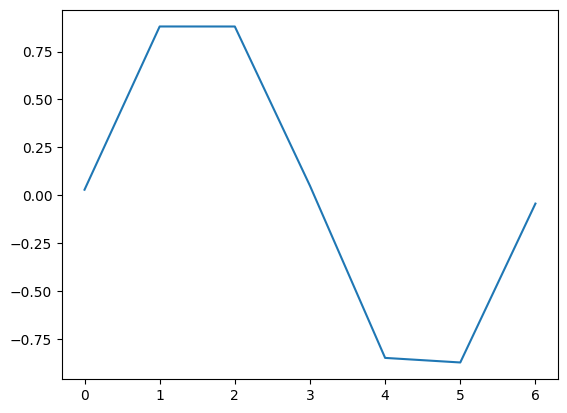

In [79]:
plt.plot(list(range(7)), h[-1][0, 3].detach().cpu().numpy())